# 8. 分子动力学模拟

我们在上一章中学到了基于蒙特卡罗算法在求解二维伊辛模型的应用。注意，我们的计算都是假设系统处在**热平衡**的状态。然而，在很多情况下，蒙特卡罗模拟可能并不好用。例如：当我们对系统达到热平衡的速度和具体过程感兴趣时，蒙特卡罗模拟将很难再应用。

而对于此类问题，直接针对粒子的微观状态进行模拟可能是一种更加实际的方法。而这就是分子动力学模拟的基本思路--通过对粒子的微观状态进行数值模拟与跟踪，最后通过统计来得到宏观态。

**具体的说，我们在这一章将要学习如何在计算机中同时追踪大量分子的运动。**

而我们的分析手段，仅仅用到了基于**牛顿第二定律**的**经典**物理知识--我们通过计算分子所受的力，再通过加速度的计算来描述粒子运动。并没有用到量子力学的理论。

热力学的知识告诉我们，分子的碰撞率$f$，和分子的数密度$n$, 散射截面$\sigma_0$，平均（相对）速度$v_{rel}$有这样的关系：

$$
f \approx n v_{rel} \sigma_0
$$

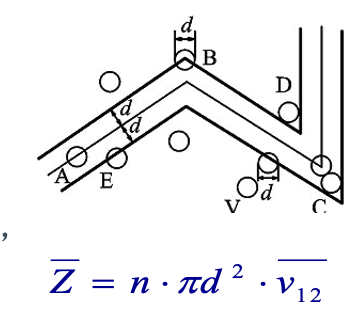

当然，我们通常也使用平均自由程$\lambda \approx v_{rel} / f \approx 1 / n \sigma_0$来表示碰撞的激烈程度。

如果用$L$来表示分子间的平均间隙（这与$\lambda$不一定相同！)，$a$为分子的大小。我们考虑在$d$维时，分子数密度则可以写为$1/L^d$，$\sigma_0\approx a^{d-1}$, 则$\lambda$为
$$
\lambda \approx \left( \frac{L}{a}\right)^d a = \left( \frac{L}{a}\right)^{d-1} L
$$

这个式子可以看出，在考虑气体或者液体时，往往有$L/a>>1$，导致$\lambda >> L >> a$。**同时，对于相同的分子间隙，我们在3维时的$\lambda$也远远大于2维时的值。** 因此，我们在这一章里仅仅只考虑粒子的二维运动。

## 8.1 Verlet方法和Lennard-Jones势

对于粒子$i$，其在$x$和$y$方向上的运动满足最基础的运动方程：
$$
\begin{eqnarray}
\frac{dx_i}{dt} &=& v_{i, x} \\
\frac{dv_{i, x}}{dt} &=& a_{i, x} \\
\frac{dy_i}{dt} &=& v_{i, y} \\
\frac{dv_{i, y}}{dt} &=& a_{i, y} \\
\end{eqnarray}
$$

其中，粒子的加速度$a_{i, x}$和$a_{i, y}$需要通过作用在粒子之上的力来计算。一旦我们能够计算力之后，就可以通过我们之前学习过的欧拉或者欧拉--柯尔莫方法来跟踪粒子的位置和速度的变化，从而实现对微观状态进行模拟。

然而，在分子动力学的模拟中，我们往往需要积分很久的时间，即在时间方向上巨量的递推次数（`n`很大）。所以，我们可能需要一个相对具有更高精度的算法。在这里，我们介绍一种具有**二阶精度**的时间积分方法---Verlet方法。

我们可以针对$x$方向上粒子的运动方程，利用我们之前介绍过的二阶中心差分的方法，将关于加速度$a$的方程写作：
$$
x_i(n+1) \approx  2  x_i(n) - x_i(n-1) + a_{i, x}(\Delta t)^2
$$

而关于速度$v$，同样可以利用具有二阶精度的差分方法：
$$
v_{i, x}(n) \approx \frac{x_i(n+1)  - x_i(n-1)}{2\Delta t}
$$

> 所谓Verlet方法，是具有二阶精度的离散化差分的递推方法。

和欧拉--科尔莫方法一样，Verlet方法也能够使能量守恒。

而且，Verlet方法也不需要求解速度$v$，仅仅利用加速度$a$的信息，就可以得到$x$关于时间的关系。但之后我们会发现，分子的速度$v$往往也包含着非常有用的信息，所以一般情况下我们也会同时计算速度$v$。

下面，让我们尝试对分子之间的相互作用力进行讨论。

在热力学中我们学过，我们可以用半经验公式

$$
F = \frac{\alpha }{r^s} - \frac{\beta}{r^t} (s>t)
$$
来大致表述分子间的相互作用力。其中，第一项为正，代表斥力；第二项为负，代表引力。

而所谓的`Lennard-Jones`模型，给我们$s=13$, $t=7$的结果。又因为$F$作为保守力可以写作$F=-dV/dr$，我们也可以得到Lennard-Jones势：
$$
V = 4 \epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6\right]
$$

注意在这里，我们重新定义了$\epsilon$和$\sigma$两个变量用以替换$F$中的$\alpha$和$\beta$，并提取出系数4方便之后的计算。

让我们先画出Lennard-Jones势：

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
def curve_plot(xs, ys, xlabel='x', ylabel='y', legends=None,
               xlim=None, ylim=None, scatter=False, title=None, figsize=(10,6), logx=False, logy=False):

    if isinstance(xs, np.ndarray):
        xs = [xs]
    if isinstance(ys, np.ndarray):
        ys = [ys]
    
    # 调整图片的大小
    plt.figure(figsize=figsize)
    
    # 画出轨迹
    for x, y in zip(xs, ys):
        if(scatter == False):
            plt.plot(x, y)
        else:
            plt.scatter(x,y)
    
    # 加入x轴标记
    plt.xlabel(xlabel, fontsize=24)
    # 加入y轴标记
    plt.ylabel(ylabel, fontsize=24)

    if(legends != None):
        plt.legend(legends, fontsize=24)
    if(xlim != None):
        plt.xlim(xlim)
    if(ylim != None):
        plt.ylim(ylim)
    if(title!= None):
        plt.title(title, fontsize=24)

    if(logx ==True):
        plt.xscale('log')
    if(logy ==True):
        plt.yscale('log')

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.show()

这里，为了方便，我们展示$V/\epsilon$和$r/\sigma$之间的关系

In [2]:
# 定义Lennard-Jones势 V_lj
def V_lj(r_over_sig):
    # 返回v/eps
    return 4 * (r_over_sig**-12 - r_over_sig**-6)


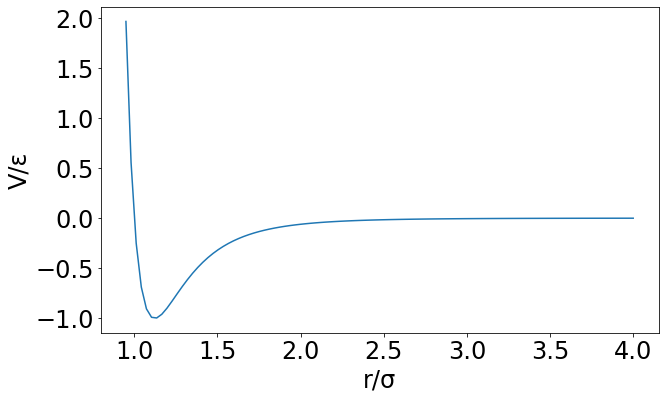

In [3]:
#创建一系列不同的r_over_sig
r_over_sig = np.linspace(0.95,4,100)
curve_plot(r_over_sig, V_lj(r_over_sig), xlabel='r/σ', ylabel='V/ε')

## 8.2 分子动力学模拟

下面，我们将使用Lennard-Jones势，对多个分子的运动进行模拟。

### 8.2.1 物理单位的确定

首先，我们需要确定我们使用的单位。因为势能$V$总是以$V/\epsilon$的形式计算，我们将尝试将$\epsilon$设置为1，我们得到的任何$V$的大小就总是以$\epsilon$为单位的。而以氩气为例子，经试验测量，其$\epsilon$大约等于满足$\epsilon / k_B = 120 K$。所以如果研究对象是氩气的话，$V$的数值多少将代表了有多少的$ k_B \cdot (120 K)$。

同理，我们也将把$\sigma$设置为1，所以一切的长度大小，都将以$\sigma$为单位。同样对于氩气，$\sigma\approx 3.4 \mathring{A}$。

我们也将把粒子质量设置为1，这意味着所有的质量数值大小都将以研究对象粒子的实际质量$m$为单位。如果研究对象是氩气，则以氩气原子质量为单位。


通过这样的单位代换，我们选定了三个基本力学单位（量纲）$[E]$, $[l]$和$[m]$，而其他单位都可以由这三个组合而成。

例如，时间量纲$[t]$可以这样来计算：

因为$[E] = [m] [l]^2/[t]^2$, 所以$[t] = \sqrt{[m] [l]^2 / [E] } = \sqrt{m \sigma^2 / \epsilon}$。即，模拟中使用的任何代表时间的数字，他的单位是$\sqrt{m \sigma^2 / \epsilon}$。

同样是对于氩气，时间单位$\sqrt{m \sigma^2 / \epsilon} \sim 1.8\times 10^{-12}s$，约等于2个皮秒。

### 8.2.2 边界条件

和在伊辛模型中类似，由于我们要模拟的对象只可能是现实中所研究系统的一小部分，**周期性边界条件**是一种常用的边界条件。

在这种边界条件下，从左边出去的粒子会从右边回来，见下图：

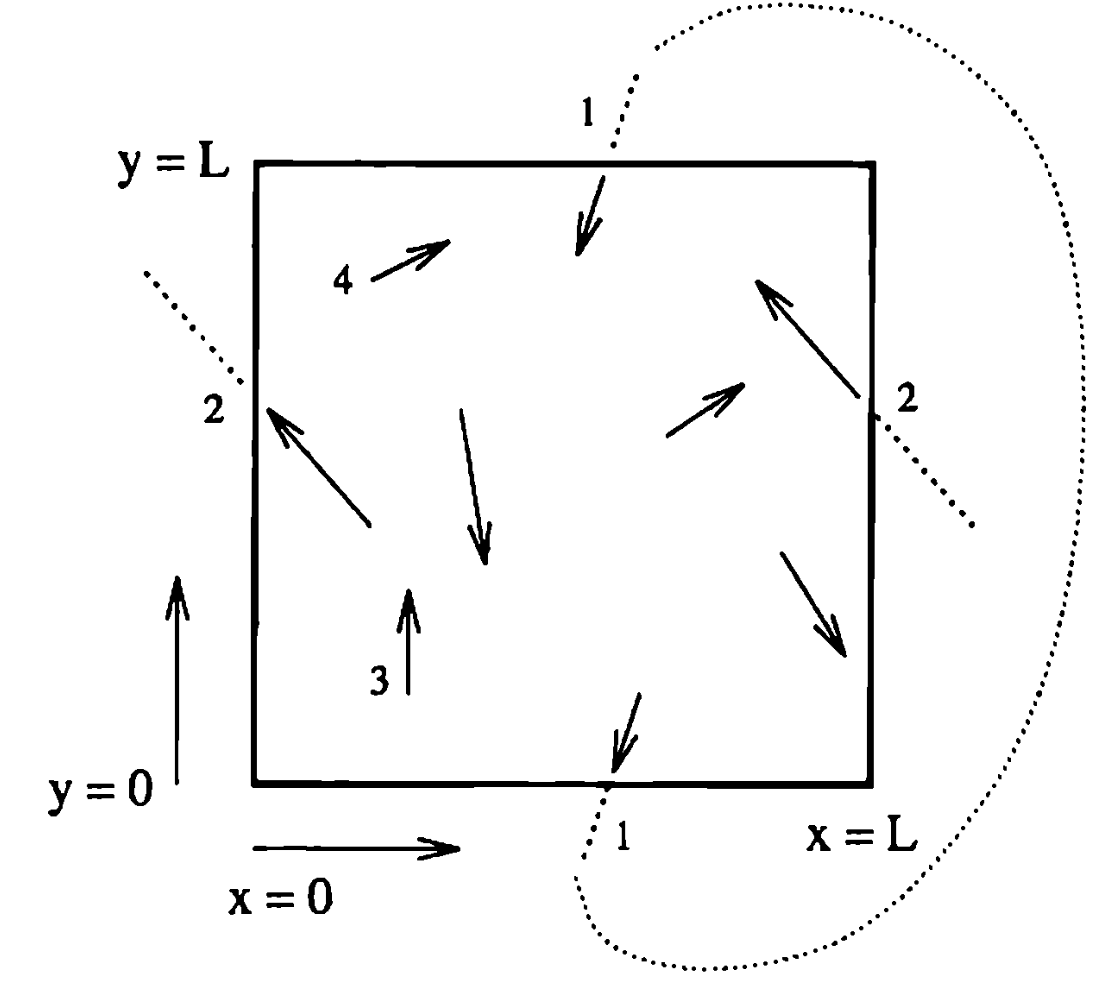

周期性边界条件，二维时几何上可以理解为一个torus。

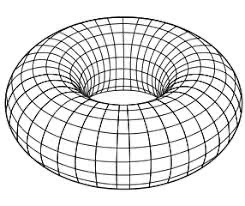

### 8.2.3 粒子的初始位置和速度

我们首先讨论如何设置模拟刚开始时的粒子的位置与速度。

关于粒子在初始时刻的位置，可能乍一看，粒子应该是均匀分布的。但实际上，我们会发现分子间的斥力在$r / \sigma < 1$时迅速增大，所以我们有理由相信，任意两个粒子的距离小于某个阈值$r_{min}$的概率为0。

为了实现这一目标，我们可以使用这样的算法：

通过循环，不断均匀的“撒”粒子。如果某个粒子撒的位置正好位于之前某个粒子的$r_{min}$的范围内，则重新“撒”该粒子，知道这个粒子并不落在之前任何一个已经撒了的粒子的$r_{min}$范围内。

通过这样的操作，我们既随机的“撒”了粒子，又满足了任意两个粒子之间的距离不小于$r_{min}$这一条件。

至于粒子的初始速度，我们可以很简单的让$x$和$y$方向上的速度在设置好的$\pm v_{max}$之间随机就可以了。

**注意！在考虑周期性边界条件时，计算粒子之间的距离$r_{k, j}$需要特别小心！**

在考虑周期性边界条件时，两个粒子真正的距离，是两个**不同方向**上的距离中，较小的那一个！

所以，在实际计算中，粒子$k$和$j$在$x$方向之间的距离$\Delta x = min[ (x_k - x_j) \mod L, (x_j - x_k) \mod L ]$。

同理，在$y$方向之间的距离$\Delta y = min[ (y_k - y_j) \mod L, (y_j - y_k) \mod L ]$。


In [4]:
# 计算位于(x0, y0)与坐标为(xs, ys)的所有粒子的距离
def pars_dist(x0, y0, xs, ys, L):
    dx = np.minimum( np.mod(x0 - xs, L), np.mod(xs - x0, L) )
    dy = np.minimum( np.mod(y0 - ys, L), np.mod(ys - y0, L) )
    return np.sqrt(dx**2 + dy**2)
    #return np.sqrt((x0 - xs)**2 + (y0 - ys)**2)
    
# 设置粒子初始位置和速度的函数
# N: 粒子数， L: 计算域的大小， r_min: 最小的初始粒子间距， v_max: 最大的速度
def pars_init(N, L, r_min, v_max):

    # 计算 (L / (2 r_min))的平方，判断其是否大于总粒子数
    # 如果该数值小于总粒子数，返回False，即表示函数没有执行成功
    if (L / (2 * r_min))**2 < N:
        raise ValueError('没有足够的空间放下所有粒子，尝试增大L!')

    xs, ys = np.zeros(N), np.zeros(N)
    for i in range(N):
        # 随机出粒子i，j的位置
        x, y = np.random.rand() * L, np.random.rand() * L
        dists = pars_dist(x, y, xs, ys, L)
        
        # 计算该位置到所有位置已经确定的粒子之间的距离
        # 如果其中任何一个大于r_min，重新随机
        while(np.any(dists[:i] < r_min) == True):
            x, y = np.random.rand() * L, np.random.rand() * L
            dists = pars_dist(x, y, xs, ys, L)
        xs[i], ys[i] = x, y
    
    vxs = 2 * (np.random.rand(N) - 0.5) * v_max
    vys = 2 * (np.random.rand(N) - 0.5) * v_max

    
    return xs, ys, vxs, vys

In [5]:
N = 20
L = 10
r_min = 0.9
v_max = 1
xs, ys, vxs, vys = pars_init(N, L, r_min, v_max)

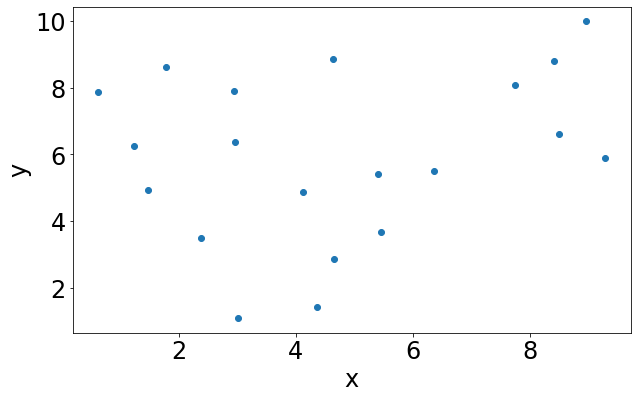

In [6]:
curve_plot(xs, ys, scatter=True)

### 8.2.4 对粒子的追踪模拟

在确定了粒子初始的状态之后，下面我们将用Verlet 方法，去跟踪粒子的运动。

Verlet方法需要利用粒子的加速度，让我们假设，对于粒子$j$，其在某时刻的加速度$a_{j, x}$和$a_{j, y}$，他们满足：

$$
a_{j, x} = \frac{1}{m} \sum_{k\neq j} f_{k,j} \cos \theta_{k, j}
$$
且
$$
a_{j, y} = \frac{1}{m} \sum_{k\neq j} f_{k,j} \sin \theta_{k, j}
$$

其中，粒子$k$和粒子$j$之间的力$f_{k,j}$为：
$$
f_{k, j} = - \frac{\partial V}{\partial r} = 24 \left(\frac{2}{ r_{k, j}^{13}} - \frac{1}{r_{k, j}^7} \right)
$$

其方向在$f_{k, j}$为正值时，应为粒子$k$指向$j$。

在考虑周期性边界条件时，两个粒子真正的距离，是两个**不同方向**上的距离中，较小的那一个！

所以，在实际计算中，粒子$k$和$j$在$x$方向之间的距离$\Delta x = min[ (x_k - x_j) \mod L, (x_j - x_k) \mod L ]$。

同理，在$y$方向之间的距离$\Delta y = min[ (y_k - y_j) \mod L, (y_j - y_k) \mod L ]$。

而$r_{k,j} = \sqrt{\Delta x^2 + \Delta y^2}$, $\cos \theta_{k, j} = \Delta x / r_{k, j}$。

In [7]:

# drift 粒子--计算粒子在dt时间之后的位置与速度
def drift(xs, ys, xs_old, ys_old, L, dt):

    xs_new = np.zeros(xs.shape)
    ys_new = np.zeros(xs.shape)

    vxs_new = np.zeros(xs.shape)
    vys_new = np.zeros(xs.shape)
    
    N = xs.shape[0]
    for i in range(N):
        # 对于粒子i， 初始化其在x和y方向上受的合力为0
        fx = 0
        fy = 0
        for j in range(N):
            if( i != j):
                # 计算粒子i和j之间的距离大小，在周期性边界条件下
                if( (xs[i] - xs[j]) % L < (xs[j] - xs[i]) % L):
                    Dx = (xs[i] - xs[j]) % L
                else:
                    Dx = - ((xs[j] - xs[i]) % L)

                if( (ys[i] - ys[j]) % L < (ys[j] - ys[i]) % L):
                    Dy = (ys[i] - ys[j]) % L
                else:
                    Dy = - ((ys[j] - ys[i]) % L)
                    
                
                r = np.sqrt(Dx**2 + Dy**2)

                # 计算粒子j对粒子i的力及其分量，并加到合力里
                f = 24 * (2 / r**13 - 1 / r**7)
                fx += (f * (Dx / r))
                fy += (f * (Dy / r))

        # 使用verlet方法计算下一步的位置
        xs_new[i] = (2 * xs[i]  - xs_old[i] + fx * dt**2) % L
        ys_new[i] = (2 * ys[i]  - ys_old[i] + fy * dt**2) % L

        # 使用中心差分的方法计算速度，注意距离需要是周期性边界条件下的距离
        if((xs_new[i] - xs_old[i]) % L < (-xs_new[i] + xs_old[i]) % L):
            vxs_new[i] = ((xs_new[i] - xs_old[i]) % L) / (2 * dt)
        else:
            vxs_new[i] = -((-xs_new[i] + xs_old[i]) % L) / (2 * dt)
            
        if((ys_new[i] - ys_old[i]) % L < (-ys_new[i] + ys_old[i]) % L):
            vys_new[i] = ((ys_new[i] - ys_old[i]) % L) / (2 * dt)
        else:
            vys_new[i] = -((-ys_new[i] + ys_old[i]) % L) / (2 * dt)   
        
    
    return xs_new, ys_new, vxs_new, vys_new
    
def advance(xs, ys, vxs, vys, tf, dt, x_trace, y_trace, vx_trace, vy_trace):
    t = 0
    xs_old = xs - vxs * dt
    ys_old = ys - vys * dt
    while(t < tf):
        xs_new, ys_new, vxs_new, vys_new = drift(xs, ys, xs_old, ys_old, L, dt)

        x_trace.append(xs_new.copy())
        y_trace.append(ys_new.copy())
        vx_trace.append(vxs_new.copy())
        vy_trace.append(vys_new.copy())
        
        xs_old = xs.copy()
        ys_old = ys.copy()
        xs = xs_new.copy()
        ys = ys_new.copy()

        
        t += dt
    return xs_new, ys_new, vxs_new, vys_new

In [8]:
%%time
dt = 0.02
x_trace = []
y_trace = []
vx_trace = []
vy_trace = []
xs_new, ys_new, vxs_new, vys_new = advance(xs, ys,vxs, vys, 2, 0.02, x_trace, y_trace, vx_trace, vy_trace)

CPU times: user 202 ms, sys: 1.9 ms, total: 204 ms
Wall time: 68 ms


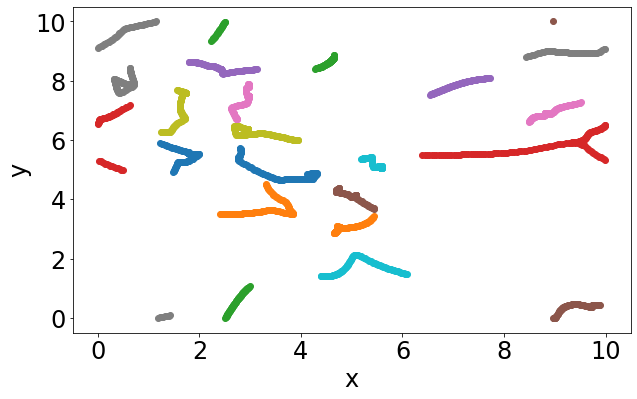

In [9]:
curve_plot([ np.array(x_trace)[:,i]  for i in range(N)], [np.array(y_trace)[:,i]  for i in range(N)], scatter=True)

可以看到，粒子的轨迹基本呈现无规则热运动的状态。且有些粒子的运动轨迹呈折线，对应了粒子的碰撞。

### 番外：矢量化的`NumPy`程序

首先我们注意到的是，尽管我们只针对20个粒子进行了模拟，每一个粒子都“前进”了仅仅100步，程序依然花费了200ms来完成。这并不是一个令人满意的效率！

再结合我们之前反复提到的，Python程序非常不擅长高效的进行`for`循环。而对于我们之前的蒙特卡罗算法，我们通过使用Cython软件包，构造C程序，来解决这一问题。

其实，如果我们能够利用`NumPy`的“向量化”计算手段，把所有粒子的位置当作一个整体来计算，也可以大大提高效率。
下面，我们给出一个向量化的，纯Python的`drift`函数。

In [10]:
# drift 粒子--计算粒子在dt时间之后的位置与速度 （向量化方法）
def drift(xs, ys, xs_old, ys_old, L, dt):

    # 计算周期性边界条件下粒子与粒子之间x和y方向上的距离
    # 结果为一个 N x N的矩阵，N为总粒子数目, 其ij元素代表对应两个粒子之间的距离
    Dxs = np.minimum(np.mod(xs[None, :] - xs[:, None], L), np.mod(xs[:, None] - xs[None, :], L))
    Dys = np.minimum(np.mod(ys[None, :] - ys[:, None], L), np.mod(ys[:, None] - ys[None, :], L))

    
    Dxs[Dxs != np.mod(xs[None, :] - xs[:, None], L)] = -Dxs[Dxs != np.mod(xs[None, :] - xs[:, None], L)]
    Dys[Dys != np.mod(ys[None, :] - ys[:, None], L)] = -Dys[Dys != np.mod(ys[None, :] - ys[:, None], L)]
    
    rs = np.sqrt(Dxs**2 + Dys**2)

    rs[rs == 0] = np.inf

    fs = 24 * (2 / rs**13 - 1 / rs**7)
    fxs = (fs * (Dxs / rs)).sum(axis=0)
    fys = (fs * (Dys / rs)).sum(axis=0)
    
    xs_new = (2 * xs  - xs_old + fxs * dt**2) % L
    ys_new = (2 * ys  - ys_old + fys * dt**2) % L

    vxs_new = np.minimum((xs_new - xs_old) % L, (-xs_new + xs_old) % L)  
    vys_new = np.minimum((ys_new - ys_old) % L, (-ys_new + ys_old) % L) 
    
    vxs_new[vxs_new != (xs_new - xs_old) % L] = - vxs_new[vxs_new != (xs_new - xs_old) % L]
    vys_new[vys_new != (ys_new - ys_old) % L] = - vys_new[vys_new != (ys_new - ys_old) % L]

    return xs_new, ys_new, vxs_new / (2 * dt), vys_new / (2 * dt)

In [11]:
%%time
dt = 0.02
x_trace = []
y_trace = []
vx_trace = []
vy_trace = []
xs_new, ys_new, vxs_new, vys_new = advance(xs, ys,vxs, vys, 2, 0.02, x_trace, y_trace, vx_trace, vy_trace)

CPU times: user 25.1 ms, sys: 1.64 ms, total: 26.7 ms
Wall time: 8.41 ms


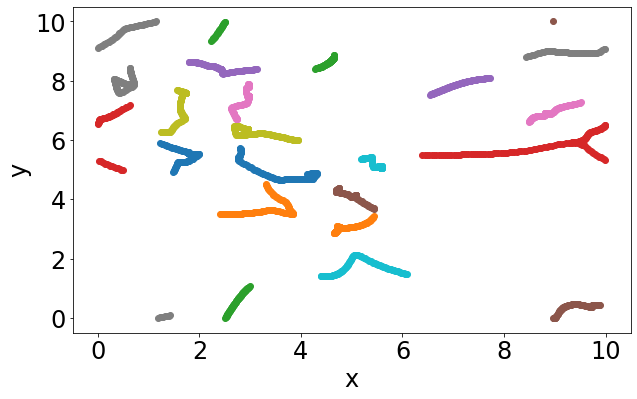

In [12]:
curve_plot([ np.array(x_trace)[:,i]  for i in range(N)], [np.array(y_trace)[:,i]  for i in range(N)], scatter=True)

可以看出，这一函数在得到同样的结果的前提下，快了近20倍，大大提高了计算速度。感兴趣的同学也可以使用`Cython`来重写`drift`函数，比较其跟矢量化的`NumPy`的效率的区别。

## 8.2.5 热平衡下的统计

如果我们所研究的这个多粒子的系统，在某一时刻进入了**热平衡**状态，那么其中粒子的速度分布，一定会满足麦克斯韦--玻尔兹曼分布：
$$
P(v) = C \frac{v^2}{k_B T} \exp \left(- m v^2 /  2  k_B T\right)
$$
其对应的$x$或$y$方向上关于速度的分布为
$$
P(v_x) = \frac{C_x}{(k_B T)^{1/2}} \exp \left(- m v_x^2 /  2  k_B T\right)
$$

下面，让我们来验证这些粒子的速度是否满足类似的分布。

这次，让我们运行程序至`t=60`的时刻，让粒子充分碰撞。

In [19]:
%%time
dt = 0.02
x_trace = []
y_trace = []
vx_trace = []
vy_trace = []

# 让t = 60
xs_new, ys_new, vxs_new, vys_new = advance(xs, ys,vxs, vys, 60, 0.005, x_trace, y_trace, vx_trace, vy_trace)

vx_trace = np.array(vx_trace)
vy_trace = np.array(vy_trace)
v_trace = np.sqrt(vx_trace**2 + vy_trace**2)

CPU times: user 929 ms, sys: 44.5 ms, total: 974 ms
Wall time: 949 ms


对应的粒子轨迹已经杂乱无章。

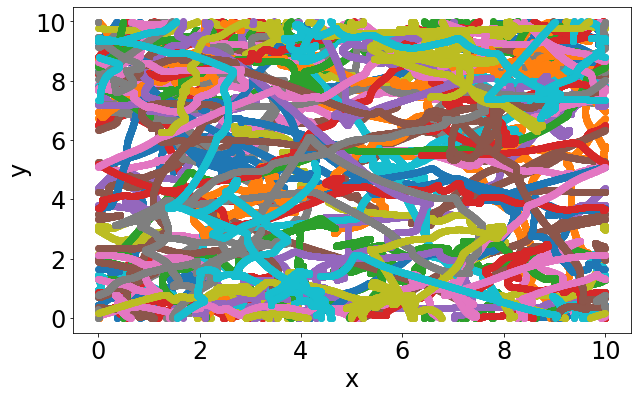

In [20]:
curve_plot([ np.array(x_trace)[:,i]  for i in range(N)], [np.array(y_trace)[:,i]  for i in range(N)], scatter=True)

首先，让我们画出在前$t<20$的时间段内，所有粒子的速度大小$v$所对应的**柱状图**。这种图描述了每一种速度出现了多少次。


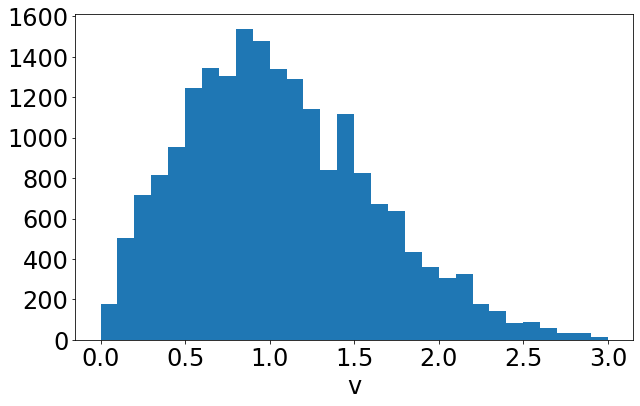

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(v_trace[:1000].flatten(), range=[0,3],bins=30)
plt.xlabel('v', fontsize='24')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

随后，我们对这个柱状图进行**归一化**，从而得到一个概率密度函数（即为概率分布函数）。并且，我们比较在$t<20$, $20<t<40$以及$40<t<60$时的分布，发现他们非常接近！

这意味着系统达到了热平衡。

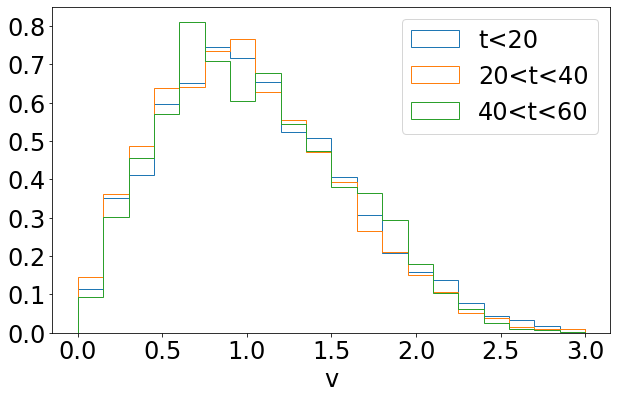

In [16]:
plt.figure(figsize=(10, 6))
# 让参数density="True"实现归一化
plt.hist(v_trace[:1000].flatten(), range=[0,3],bins=20, histtype="step", density="True")
plt.hist(v_trace[1000:2000].flatten(), range=[0,3],bins=20, histtype="step", density="True")
plt.hist(v_trace[2000:].flatten(), range=[0,3],bins=20, histtype="step", density="True")

plt.xlabel('v', fontsize='24')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(['t<20', '20<t<40', '40<t<60'], fontsize=24)
plt.show()

类似的，我们可以画出$v_x$的分布，理论上$v_x$应该满足中心在0的高斯分布。

事实上，的确如此。而且，和$v$的分布一样，$v_x$在$t<20$, $20<t<40$以及$40<t<60$时的分布也非常接近。说明系统在多次频繁碰撞后进入了热平衡状态。

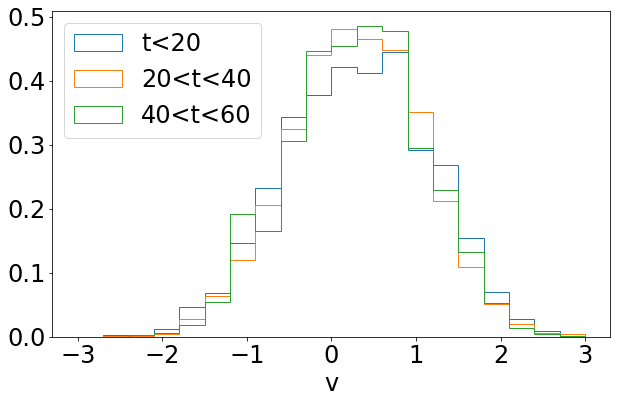

In [17]:
plt.figure(figsize=(10, 6))
# 让参数density="True"实现归一化
plt.hist(vx_trace[:1000].flatten(), range=[-3,3],bins=20, histtype="step", density="True")
plt.hist(vx_trace[1000:2000].flatten(), range=[-3,3],bins=20, histtype="step", density="True")
plt.hist(vx_trace[2000:].flatten(), range=[-3,3],bins=20, histtype="step", density="True")

plt.xlabel('v', fontsize='24')
plt.legend(['t<20', '20<t<40', '40<t<60'], fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

### 我们究竟在计算什么？

初始的粒子的速度分布显然不满足麦克斯韦速度分布。但这个系统（微正则系综）的粒子的速度分布，的确很快的向平衡态的麦克斯韦分布靠拢。

这种性质的确与处在平衡态中的系统非常类似----无论系统怎样偏离平衡态，只要系统的温度不变，系统总会回到在该温度下热平衡时对应的状态。

而又由于温度并不是我们在这里的模拟中的参量（和伊辛模型不同），我们在对分子动力学的模拟中，应该去尝试从模拟结果中，提取出温度$T$这一属性。

回忆热学中学到过的，分子的每一个自由度，对应了一份$k_B T / 2$的能量。例如，分子在$x$方向的平均平动动能，满足
$$
\frac12 m \bar{v^2_x} = k_B T / 2
$$

所以，温度也可以由这种方法求得。

In [18]:
T = (vx_trace[:]**2 ).mean()
print(T)

0.7403182167426683


如果研究的对象是氩气，这代表了对应的温度为$0.7 \times 120 \, \mathrm{K}$（思考一下为什么是这样的单位）。